# Hate Speech Detection - ANN Baseline

This notebook implements an Artificial Neural Network (ANN) as a baseline model for hate speech/offensive language detection. It uses the same datasets and preprocessing pipeline as the main RoBERTa project for fair comparison.

**Features:**
1.  **Configuration Cell:** Centralized parameters.
2.  **Data Loading & Preprocessing:** Handles TXT and TSV/CSV, uses the same text cleaning, and TF-IDF for feature extraction.
3.  **ANN Model:** A simple feed-forward neural network.
4.  **Training Loop:** Standard PyTorch training with early stopping.
5.  **Evaluation:** Standard classification metrics.
6.  **Artifact Saving:** Saves model, vectorizer, results, and plots.
7.  **WandB Sweep Config:** For hyperparameter optimization.

## 1. Imports

In [48]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # Mitigate fragmentation

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import json
import time
import random
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm
import re, html
import joblib # For saving/loading the TfidfVectorizer
import emoji
import wandb

## 2. Configuration (Code Cell)

In [49]:
# --- Core ANN Configuration ---

MAX_FEATURES = 10000      # Max features for TF-IDF
ANN_HIDDEN_DIM = 256    # Hidden dimension for ANN
ANN_LAYERS = 2          # Number of hidden layers (fc1, fc2 in your example means 2 hidden layers before output)
DROPOUT_PROB = 0.32723932556190316      # Dropout probability
BATCH_SIZE = 64         # Batch size
EPOCHS = 20             # Number of training epochs (ANNs might need more than transformers for convergence)
LEARNING_RATE = 0.0001239494604246138    # Learning rate for ANN (typically higher than for transformers)
WEIGHT_DECAY = 0.0003268076158549376     # Weight decay for AdamW optimizer
SEED = 42               # Random seed for reproducibility
OUTPUT_DIR = 'ann_model_output' # Directory to save model, results, plots
VAL_SPLIT_SIZE = 0.15   # Proportion of training data to use for validation

# --- Feature Flags ---
USE_EARLY_STOPPING = True # Set to True to enable early stopping
PATIENCE = 5            # Number of epochs to wait for improvement before stopping
ACCUMULATION_STEPS = 1  # Gradient accumulation (typically 1 for ANNs unless very large batches simulated)

# --- Dataset Configuration (Should match your RoBERTa project for comparison) ---
BASE_DIR = os.getcwd()
print("Base dir:", BASE_DIR)
DATASET_TYPE = 'HASOC' # Options: 'OLID', 'HASOC', 'OffenseEval'
SUBTASK = '1'        # e.g. HASOC subtask 1, 2, or 3; OLID subtask a, b, or c

# --- File paths (Adjust as per your RoBERTa project structure) ---
if DATASET_TYPE == 'OLID':
    DATA_DIR   = os.path.join(BASE_DIR, 'OlidPreprcessed') # Ensure this path exists
    TRAIN_FILE = os.path.join(DATA_DIR, 'OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt')
    TEST_FILE  = os.path.join(DATA_DIR, f'OLID_TEST_{SUBTASK.upper()}_ATUSER_URL_EmojiRemoved_Pedro.txt')
    TEST_LABELS_FILE = None
    TEXT_COLUMN = 'tweet'
    LABEL_COLUMN = f'subtask_{SUBTASK.lower()}'
    if SUBTASK == 'a': LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b': LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else: LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}

elif DATASET_TYPE == 'HASOC':
    DATA_DIR    = os.path.join(BASE_DIR, 'HASOCData') # Ensure this path exists
    TRAIN_FILE  = os.path.join(DATA_DIR, 'english_dataset.tsv')
    TEST_FILE   = os.path.join(DATA_DIR, 'hasoc2019_en_test-2919.tsv')
    TEST_LABELS_FILE = None # os.path.join(DATA_DIR, 'english_dataset_labels_subtask_c.tsv') # Example if you have one
    TEXT_COLUMN  = 'tweet' # Or 'text' depending on your tsv file
    LABEL_COLUMN = f'task_{SUBTASK}'
    if SUBTASK == '1': LABEL_MAP = {'NOT': 0, 'HOF': 1}
    elif SUBTASK == '2': LABEL_MAP = {'HATE': 0, 'OFFN': 1, 'PRFN': 2}
    else: LABEL_MAP = {'TIN': 0, 'UNT': 1} # Adjusted to match your RoBERTa project's TIN/UNT mapping for HASOC 3 if needed

elif DATASET_TYPE == 'OffenseEval':
    DATA_DIR = os.path.join(BASE_DIR, 'OffenseEval') # Ensure this path exists
    if SUBTASK == 'a':
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_a_train.tsv') # Example, adjust to your combined file or logic
    elif SUBTASK == 'b':
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_b_train.tsv') # Example
    else: # 'c'
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_c_train.tsv') # Example
    TEST_FILE = os.path.join(DATA_DIR, f'test_{SUBTASK}.tsv')
    TEST_LABELS_FILE = os.path.join(DATA_DIR, f'labels_{SUBTASK}.csv') # Example
    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'subtask_{SUBTASK}'
    if SUBTASK == 'a': LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b': LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else: LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
else:
    raise ValueError("Invalid DATASET_TYPE.")

print(f"Train file: {TRAIN_FILE}")
NUM_LABELS = len(LABEL_MAP)
if NUM_LABELS == 2: # Binary classification with 0 and 1
    OUTPUT_DIM_ANN = 1 # Single output neuron with Sigmoid if using BCELoss
else: # Multi-class
    OUTPUT_DIM_ANN = NUM_LABELS # NUM_LABELS output neurons if using CrossEntropyLoss


# --- Create output directory ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Configuration to JSON ---
config_ann_dict = {
    'MAX_FEATURES': MAX_FEATURES,
    'ANN_HIDDEN_DIM': ANN_HIDDEN_DIM,
    'ANN_LAYERS': ANN_LAYERS,
    'DROPOUT_PROB': DROPOUT_PROB,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'SEED': SEED,
    'OUTPUT_DIR': OUTPUT_DIR,
    'DATASET_TYPE': DATASET_TYPE,
    'SUBTASK': SUBTASK,
    'TRAIN_FILE': TRAIN_FILE,
    'TEST_FILE': TEST_FILE,
    'TEST_LABELS_FILE': TEST_LABELS_FILE,
    'TEXT_COLUMN': TEXT_COLUMN,
    'LABEL_COLUMN': LABEL_COLUMN,
    'LABEL_MAP': LABEL_MAP,
    'NUM_LABELS': NUM_LABELS,
    'VAL_SPLIT_SIZE': VAL_SPLIT_SIZE,
    'USE_EARLY_STOPPING': USE_EARLY_STOPPING,
    'PATIENCE': PATIENCE if USE_EARLY_STOPPING else None,
    'ACCUMULATION_STEPS': ACCUMULATION_STEPS
}
config_filename = f"config_ann_{DATASET_TYPE}.json"
config_path = os.path.join(OUTPUT_DIR, config_filename)
with open(config_path, 'w') as f:
    json.dump(config_ann_dict, f, indent=4)
print(f"Configuration saved to {config_path}")

Base dir: /
Train file: /HASOCData/english_dataset.tsv
Configuration saved to ann_model_output/config_ann_HASOC.json


## 3. Environment Setup

In [50]:
def set_seed(seed_value: int):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # Optional: for full determinism, but can slow down
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False
set_seed(SEED)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 2080 Ti


## 4. Data Preprocessing Functions

In [51]:
def preprocess_text(text: str) -> str:
    text = str(text).lower()
    contractions = {
        r"\bcan't\b": "can not", r"\bdon't\b": "do not", r"\bit's\b": "it is",
        r"\bi'm\b": "i am", r"\bwe're\b": "we are", r"\byou're\b": "you are",
        r"\bthey're\b": "they are", r"\bhe's\b": "he is", r"\bshe's\b": "she is",
        r"\bwon't\b": "will not", r"\bwouldn't\b": "would not", r"\bshouldn't\b": "should not",
        r"\bhasn't\b": "has not", r"\bhaven't\b": "have not", r"\bhadn't\b": "had not",
        r"\bdoesn't\b": "does not", r"\bdidn't\b": "did not", r"\bwasn't\b": "was not",
        r"\bwhat's\b": "what is", r"\bwhere's\b": "where is", r"\bwho's\b": "who is",
        r"\bthere's\b": "there is", r"\blet's\b": "let us", r"\bthat's\b": "that is",
        r"\bwho've\b": "who have", r"\bwho'll\b": "who will", r"\bwho'd\b": "who would",
    }
    for pat, rep in contractions.items():
        text = re.sub(pat, rep, text)
    text = re.sub(r'@\w+', '@user', text)
    text = re.sub(r'http\S+|www\.\S+', 'httpurl', text)
    text = html.unescape(text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    demoj = emoji.demojize(text)
    demoj = demoj.replace(':', ' ').replace('_', ' ')
    text = demoj
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'(?<!!)\\!(?=\s)', '', text) # Remove single '!' if followed by space, keep "!!"
    text = re.sub(r'\s+([.,!?"])', r'\1', text) # Remove spaces before punctuation
    return text

def load_and_preprocess_data(
    train_path: str, test_path: str, text_col: str, label_col: str, label_map: Dict[str, int],
    test_labels_path: Optional[str] = None, val_split: float = 0.1, seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    # Use na_filter=False and keep_default_na=False to treat empty strings as "" not NaN
    df_train = pd.read_csv(train_path, sep='\t', dtype=str, keep_default_na=False, na_filter=False)
    df_test  = pd.read_csv(test_path,  sep='\t', dtype=str, keep_default_na=False, na_filter=False)

    if test_labels_path and os.path.exists(test_labels_path):
        df_labels = pd.read_csv(test_labels_path, sep='\t', dtype=str, keep_default_na=False, na_filter=False)
        # Ensure columns for merging exist
        if 'id' in df_test.columns and 'id' in df_labels.columns and label_col in df_labels.columns:
             df_test = df_test.merge(df_labels[['id', label_col]], on='id', how='left')
        else:
            print(f"Warning: Could not merge test labels. 'id' column or label column '{label_col}' missing in test_path or test_labels_path DFs.")
            if label_col not in df_test.columns: # If label_col not in test_df at all
                 df_test[label_col] = "" # Add it as empty strings

    # Filter train data for known labels BEFORE preprocessing text
    df_train = df_train[df_train[label_col].isin(label_map)].copy()
    df_train['label'] = df_train[label_col].map(label_map).astype(int)

    # Preprocess text
    df_train['clean_text'] = df_train[text_col].apply(preprocess_text)
    
    # Drop rows if clean_text is empty OR if original text was empty
    before = len(df_train)
    df_train.dropna(subset=['clean_text', 'label'], inplace=True) # label should be fine now
    df_train = df_train[df_train['clean_text'].str.len().gt(0)]
    df_train = df_train[df_train[text_col].str.len().gt(0)] # Also check original text
    print(f"Dropped {before - len(df_train)} train rows due to empty text (original or cleaned) or missing label after map.")

    # Process test data
    df_test['clean_text'] = df_test[text_col].apply(preprocess_text)
    if label_col in df_test.columns:
        df_test['label_original'] = df_test[label_col] # keep original for potential analysis
        # Filter for known labels for the 'label' column; keep rows with unknown/NaN labels for inference
        # but ensure they don't cause errors in mapping
        known_labels_mask = df_test[label_col].isin(label_map)
        df_test_known = df_test[known_labels_mask].copy()
        df_test_unknown = df_test[~known_labels_mask].copy()

        if not df_test_known.empty:
            df_test_known['label'] = df_test_known[label_col].map(label_map).astype(int)
        else: # If no known labels, ensure 'label' column exists with appropriate type
            df_test_known['label'] = pd.Series(dtype=int)
        
        df_test_unknown['label'] = np.nan # Or some other placeholder like -1 if int type is strict later
        df_test = pd.concat([df_test_known, df_test_unknown]).sort_index()
        
    before_test = len(df_test)
    df_test.dropna(subset=['clean_text'], inplace=True) # only drop if cleaned text is bad
    df_test = df_test[df_test['clean_text'].str.len().gt(0)]
    df_test = df_test[df_test[text_col].str.len().gt(0)] # Also check original text
    print(f"Dropped {before_test - len(df_test)} test rows due to empty text (original or cleaned).")

    # Stratified split on train data
    if df_train.empty or 'label' not in df_train.columns or df_train['label'].nunique() < 2 :
        print("Warning: Not enough data or classes for stratified split. Using simple split or returning empty DFs.")
        # Fallback to simple split if stratification is not possible or handle error
        if len(df_train) < 2 : # Need at least 2 samples for train_test_split
            df_tr, df_val = df_train, pd.DataFrame(columns=df_train.columns)
        else:
            df_tr, df_val = train_test_split(
                df_train[['clean_text', 'label']], test_size=val_split, random_state=seed
            ) # No stratify
    else:
        df_tr, df_val = train_test_split(
            df_train[['clean_text', 'label']], test_size=val_split, 
            stratify=df_train['label'], random_state=seed
        )
    return df_tr.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

## 5. Load Data, Preprocess, and Vectorize

In [52]:
print("Loading and preprocessing data for ANN...")
df_train, df_val, df_test = load_and_preprocess_data(
    train_path=TRAIN_FILE, test_path=TEST_FILE, text_col=TEXT_COLUMN,
    label_col=LABEL_COLUMN, label_map=LABEL_MAP, test_labels_path=TEST_LABELS_FILE,
    val_split=VAL_SPLIT_SIZE, seed=SEED
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 2), stop_words='english')

# Fit on training data ONLY, then transform all sets
if not df_train.empty:
    X_train_tfidf = vectorizer.fit_transform(df_train['clean_text']).toarray()
    y_train = df_train['label'].values
else:
    X_train_tfidf = np.array([])
    y_train = np.array([])

if not df_val.empty:
    X_val_tfidf = vectorizer.transform(df_val['clean_text']).toarray()
    y_val = df_val['label'].values
else:
    X_val_tfidf = np.array([])
    y_val = np.array([])

if df_test is not None and not df_test.empty:
    X_test_tfidf = vectorizer.transform(df_test['clean_text']).toarray()
    if 'label' in df_test.columns and df_test['label'].notna().any():
        y_test = df_test['label'].dropna().astype(int).values # Ensure labels are int and dropna before converting
        # Align X_test_tfidf if y_test was filtered due to NaNs
        if len(y_test) != len(X_test_tfidf):
             X_test_tfidf = vectorizer.transform(df_test.loc[df_test['label'].notna(), 'clean_text']).toarray()
    else:
        y_test = None
else:
    X_test_tfidf = np.array([])
    y_test = None

print(f"TF-IDF Vectorizer fitted on training data. Vocab size: {len(vectorizer.vocabulary_) if hasattr(vectorizer, 'vocabulary_') else 'N/A (no train data)'}")
print(f"X_train shape: {X_train_tfidf.shape}, X_val shape: {X_val_tfidf.shape}, X_test shape: {X_test_tfidf.shape if X_test_tfidf.size > 0 else 'N/A'}")

print(f"Train: {len(df_train)} rows; Val: {len(df_val)} rows; Test: {len(df_test) if df_test is not None else 'N/A'}")
if not df_train.empty: print("Train label dist:\n", df_train['label'].value_counts(normalize=True))
if not df_val.empty: print("Val   label dist:\n", df_val['label'].value_counts(normalize=True))

if y_test is not None:
    # Need to get the labels from df_test for the rows that correspond to X_test_tfidf
    if 'label' in df_test.columns and df_test['label'].notna().any():
        test_label_dist_df = df_test[df_test['label'].notna()].copy()
        test_label_dist_df['label'] = test_label_dist_df['label'].astype(int) # Ensure it's int for value_counts
        print("Test  label dist:\n", test_label_dist_df['label'].value_counts(normalize=True))
    else:
         print("Test label dist: N/A (test set may be unlabeled or empty after processing)")
else:
    print("Test  label dist: N/A (test set may be unlabeled or empty after processing)")


# Save the vectorizer
vectorizer_path = os.path.join(OUTPUT_DIR, f'tfidf_vectorizer_{DATASET_TYPE}.joblib')
if hasattr(vectorizer, 'vocabulary_') and vectorizer.vocabulary_: # only save if fitted
    joblib.dump(vectorizer, vectorizer_path)
    print(f"TF-IDF vectorizer saved to {vectorizer_path}")
else:
    print("TF-IDF vectorizer not saved as it was not fitted (likely no training data).")

Loading and preprocessing data for ANN...
Dropped 0 train rows due to empty text (original or cleaned) or missing label after map.
Dropped 0 test rows due to empty text (original or cleaned).
TF-IDF Vectorizer fitted on training data. Vocab size: 10000
X_train shape: (4974, 10000), X_val shape: (878, 10000), X_test shape: (1153, 10000)
Train: 4974 rows; Val: 878 rows; Test: 1153
Train label dist:
 label
0    0.613591
1    0.386409
Name: proportion, dtype: float64
Val   label dist:
 label
0    0.613895
1    0.386105
Name: proportion, dtype: float64
Test  label dist:
 label
0    0.750217
1    0.249783
Name: proportion, dtype: float64
TF-IDF vectorizer saved to ann_model_output/tfidf_vectorizer_HASOC.joblib


## 6. PyTorch Dataset and DataLoader for ANN

In [53]:
class ANNClassificationDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        if labels is not None and len(labels) > 0 : # Check if labels exist and are not empty
            self.labels = torch.tensor(labels, dtype=torch.long) # CrossEntropyLoss expects long
        else:
            self.labels = None

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        item = {'features': self.features[idx]}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

num_workers = 0     # 1 # min(2, os.cpu_count() or 1)
pin_memory  = torch.cuda.is_available()

if X_train_tfidf.size > 0:
    train_ann_dataset = ANNClassificationDataset(X_train_tfidf, y_train)
    train_ann_loader = DataLoader(train_ann_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    print(f"Train loader: {len(train_ann_dataset)} samples")
else:
    train_ann_loader = None
    print("Train loader: No training data.")


if X_val_tfidf.size > 0:
    val_ann_dataset = ANNClassificationDataset(X_val_tfidf, y_val)
    val_ann_loader = DataLoader(val_ann_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    print(f"Val loader: {len(val_ann_dataset)} samples")
else:
    val_ann_loader = None
    print("Val loader: No validation data.")


test_ann_loader = None
if X_test_tfidf.size > 0 and y_test is not None and len(y_test) == len(X_test_tfidf):
    test_ann_dataset = ANNClassificationDataset(X_test_tfidf, y_test)
    test_ann_loader = DataLoader(test_ann_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    print(f"Test loader: {len(test_ann_dataset)} samples (labeled)")
elif X_test_tfidf.size > 0:
    # For inference on unlabeled test data
    test_ann_dataset_unlabeled = ANNClassificationDataset(X_test_tfidf, None)
    test_ann_loader = DataLoader(test_ann_dataset_unlabeled, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    print(f"Test loader: {len(test_ann_dataset_unlabeled)} samples (unlabeled for inference)")
else:
    print("No test data to create a loader for.")

Train loader: 4974 samples
Val loader: 878 samples
Test loader: 1153 samples (labeled)


## 7. ANN Model Definition

In [54]:
class SimpleANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers, dropout_prob):
        super(SimpleANN, self).__init__()
        layers = []
        current_dim = input_dim
        
        if num_hidden_layers == 0: # Direct linear model if no hidden layers
            layers.append(nn.Linear(current_dim, output_dim))
        else:
            # First hidden layer
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            current_dim = hidden_dim

            # Subsequent hidden layers (if num_hidden_layers > 1)
            for _ in range(num_hidden_layers - 1):
                next_hidden_dim = hidden_dim // 2
                if next_hidden_dim < output_dim and num_hidden_layers > 1 : # Ensure hidden dim doesn't get too small
                     next_hidden_dim = max(output_dim, 16) # or some other sensible minimum
                
                layers.append(nn.Linear(current_dim, next_hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_prob))
                current_dim = next_hidden_dim
                hidden_dim = next_hidden_dim # for the next iteration
            
            # Output layer
            layers.append(nn.Linear(current_dim, output_dim))
        
        # For CrossEntropyLoss, the model should output raw logits.
        # No final Sigmoid (for BCELoss) or Softmax (for NLLLoss after LogSoftmax).
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Determine output_dim based on NUM_LABELS
# If NUM_LABELS is 2, it's binary. CrossEntropyLoss can handle 2 output neurons or 1 with BCELossWithLogits.
# For consistency with multi-class, let's use NUM_LABELS output neurons for CrossEntropyLoss.
actual_output_dim_ann = NUM_LABELS if NUM_LABELS > 2 else (1 if NUM_LABELS == 2 else NUM_LABELS) # For BCELossWithLogits with binary
if NUM_LABELS == 2: actual_output_dim_ann = 2 # For CrossEntropyLoss with binary

ann_model = SimpleANN(
    input_dim=MAX_FEATURES, 
    hidden_dim=ANN_HIDDEN_DIM, 
    output_dim=actual_output_dim_ann, 
    num_hidden_layers=ANN_LAYERS, # This is the number of *hidden* layers
    dropout_prob=DROPOUT_PROB
).to(device)

print(ann_model)
print(f"ANN output dimension: {actual_output_dim_ann}")

SimpleANN(
  (network): Sequential(
    (0): Linear(in_features=10000, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.32723932556190316, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.32723932556190316, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
ANN output dimension: 2


## 8. Training Loop Functions for ANN

In [55]:
def train_ann_epoch(model, data_loader, loss_fn, optimizer, device, scaler, scheduler=None, accumulation_steps=1):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    if accumulation_steps > 1:
        optimizer.zero_grad(set_to_none=True)

    for i, batch in enumerate(tqdm(data_loader, desc="Training ANN", unit="batch", leave=False)):
        features = batch['features'].to(device)
        labels = batch['labels'].to(device)
        batch_size_actual = features.size(0)

        if accumulation_steps == 1 or (i % accumulation_steps == 0) :
            optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            outputs = model(features)
            # If binary classification and output_dim is 1 (for BCELossWithLogits)
            if outputs.shape[1] == 1 and NUM_LABELS == 2: # Assuming binary implies NUM_LABELS=2
                loss = loss_fn(outputs.squeeze(1), labels.float()) # BCELossWithLogits expects float labels
            else: # Multi-class or binary with 2 output neurons for CrossEntropyLoss
                loss = loss_fn(outputs, labels)
            
            if accumulation_steps > 1:
                loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            if scheduler: scheduler.step()
            if accumulation_steps > 1 and (i + 1) != len(data_loader):
                 optimizer.zero_grad(set_to_none=True)
        
        if outputs.shape[1] == 1 and NUM_LABELS == 2:
            preds = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()
        else:
            preds = torch.argmax(outputs, dim=1)
            
        correct_predictions += torch.sum(preds == labels).item()
        # De-normalize loss if accumulated
        total_loss += loss.item() * batch_size_actual * (accumulation_steps if accumulation_steps > 1 and loss.item() != 0 else 1)
        total_samples += batch_size_actual
        
        del features, labels, outputs, loss, preds
        if device.type == 'cuda': torch.cuda.empty_cache()

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    avg_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return avg_loss, avg_acc

def eval_ann_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating ANN", unit="batch", leave=False):
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            batch_size_actual = features.size(0)

            with autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(features)
                if outputs.shape[1] == 1 and NUM_LABELS == 2:
                     loss = loss_fn(outputs.squeeze(1), labels.float())
                else:
                     loss = loss_fn(outputs, labels)
            
            if outputs.shape[1] == 1 and NUM_LABELS == 2:
                preds = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long()
            else:
                preds = torch.argmax(outputs, dim=1)

            correct_predictions += torch.sum(preds == labels).item()
            total_loss += loss.item() * batch_size_actual
            total_samples += batch_size_actual
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            
            del features, labels, outputs, loss, preds
            if device.type == 'cuda': torch.cuda.empty_cache()

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    # Ensure all_labels and all_preds are not empty before calling metrics
    if not all_labels or not all_preds:
        return avg_loss, 0, 0, 0, 0, [], []

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, accuracy, f1, precision, recall, all_labels, all_preds

## 9. ANN Training and Validation Driver

In [56]:
if train_ann_loader: # Proceed only if there is training data
    print("Computing class weights for ANN...")
    classes_ann = np.unique(y_train)
    if len(classes_ann) > 1: # Ensure there's more than one class for balancing
        weights_ann = compute_class_weight(class_weight='balanced', classes=classes_ann, y=y_train)
        class_weights_ann = torch.tensor(weights_ann, dtype=torch.float).to(device)
        print("Class weights:", dict(zip(classes_ann, weights_ann)))
    else:
        print("Only one class in training data or no data. Not using class weights.")
        class_weights_ann = None

    # Loss function choice
    if actual_output_dim_ann == 1 and NUM_LABELS == 2: # Binary with single output
        loss_fn_ann = nn.BCEWithLogitsLoss(weight=class_weights_ann[1] if class_weights_ann is not None and len(class_weights_ann)==2 else None).to(device)
        print("Using BCEWithLogitsLoss for binary classification.")
    else: # Multi-class or binary with NUM_LABELS output neurons
        loss_fn_ann = nn.CrossEntropyLoss(weight=class_weights_ann).to(device)
        print("Using CrossEntropyLoss.")
        
    optimizer_ann = AdamW(ann_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler_ann = GradScaler(enabled=(device.type == 'cuda'))
    scheduler_ann = None # Or define one: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ann, 'min', patience=2, factor=0.5)

    history_ann = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_val_loss_ann = float('inf')
    epochs_no_improve_ann = 0
    best_model_state_ann = None
    best_epoch_ann = 0
    total_training_time_seconds_ann = 0

    print(f"Starting ANN training for {EPOCHS} epochs...")
    training_start_time_ann = time.time()

    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch}/{EPOCHS}")
        
        train_loss, train_acc = train_ann_epoch(
            ann_model, train_ann_loader, loss_fn_ann, optimizer_ann, device, scaler_ann, scheduler_ann, ACCUMULATION_STEPS
        )
        print(f"Train -> loss: {train_loss:.4f}, acc: {train_acc:.4f}")

        if val_ann_loader: # Only evaluate if there is validation data
            val_loss, val_acc, val_f1, val_prec, val_rec, _, _ = eval_ann_model(
                ann_model, val_ann_loader, loss_fn_ann, device
            )
            print(f"Val   -> loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}, prec: {val_prec:.4f}, rec: {val_rec:.4f}")

            history_ann['train_loss'].append(train_loss)
            history_ann['train_acc'].append(train_acc)
            history_ann['val_loss'].append(val_loss)
            history_ann['val_acc'].append(val_acc)
            history_ann['val_f1'].append(val_f1)

            if val_loss < best_val_loss_ann:
                best_val_loss_ann = val_loss
                best_epoch_ann = epoch
                epochs_no_improve_ann = 0
                best_model_state_ann = deepcopy(ann_model.state_dict())
                print("✔️ New best ANN model saved.")
            else:
                epochs_no_improve_ann += 1
                print(f"⏳ No improvement for ANN: {epochs_no_improve_ann}/{PATIENCE}")

            if USE_EARLY_STOPPING and epochs_no_improve_ann >= PATIENCE:
                print("🛑 Early stopping triggered for ANN.")
                break
            
            if scheduler_ann and isinstance(scheduler_ann, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler_ann.step(val_loss)
            elif scheduler_ann: # for other schedulers like StepLR
                scheduler_ann.step()

        else: # No validation data
            history_ann['train_loss'].append(train_loss)
            history_ann['train_acc'].append(train_acc)
            # If no validation, save model at each epoch or based on train loss (less ideal)
            if train_loss < best_val_loss_ann: # Using train_loss as proxy
                best_val_loss_ann = train_loss
                best_epoch_ann = epoch
                best_model_state_ann = deepcopy(ann_model.state_dict())
                print("✔️ ANN model saved (based on train loss).")
        
        epoch_end_time = time.time()
        print(f"Epoch {epoch} took {epoch_end_time - epoch_start_time:.2f} seconds.")

    total_training_time_seconds_ann = time.time() - training_start_time_ann
    print(f"\nTotal ANN training time: {total_training_time_seconds_ann:.2f} seconds.")

    if best_model_state_ann is not None:
        print(f"\nLoading best ANN model state from epoch {best_epoch_ann} for final evaluation and saving...")
        ann_model.load_state_dict(best_model_state_ann)
    else:
        print("\nWarning: No best ANN model state saved (e.g. no validation data or no improvement). Using final model state.")

    print("ANN Training complete.")
else:
    print("Skipping ANN training as no training data is available.")

Computing class weights for ANN...
Class weights: {np.int64(0): np.float64(0.814875491480996), np.int64(1): np.float64(1.293964620187305)}
Using CrossEntropyLoss.
Starting ANN training for 20 epochs...

Epoch 1/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.6932, acc: 0.6136


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.6927, acc: 0.6139, f1: 0.4670, prec: 0.3769, rec: 0.6139
✔️ New best ANN model saved.
Epoch 1 took 0.45 seconds.

Epoch 2/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.6886, acc: 0.6355


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.6876, acc: 0.6458, f1: 0.6117, prec: 0.6306, rec: 0.6458
✔️ New best ANN model saved.
Epoch 2 took 0.41 seconds.

Epoch 3/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.6628, acc: 0.7441


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.6705, acc: 0.6082, f1: 0.6122, prec: 0.6204, rec: 0.6082
✔️ New best ANN model saved.
Epoch 3 took 0.41 seconds.

Epoch 4/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.5910, acc: 0.7670


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.6577, acc: 0.5866, f1: 0.5920, prec: 0.6104, rec: 0.5866
✔️ New best ANN model saved.
Epoch 4 took 0.40 seconds.

Epoch 5/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.4818, acc: 0.8152


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.6768, acc: 0.6071, f1: 0.6116, prec: 0.6222, rec: 0.6071
⏳ No improvement for ANN: 1/5
Epoch 5 took 0.40 seconds.

Epoch 6/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.3782, acc: 0.8651


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.7232, acc: 0.6093, f1: 0.6137, prec: 0.6239, rec: 0.6093
⏳ No improvement for ANN: 2/5
Epoch 6 took 0.41 seconds.

Epoch 7/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.3001, acc: 0.8947


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.7866, acc: 0.6162, f1: 0.6180, prec: 0.6203, rec: 0.6162
⏳ No improvement for ANN: 3/5
Epoch 7 took 0.41 seconds.

Epoch 8/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.2311, acc: 0.9256


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.8597, acc: 0.6116, f1: 0.6158, prec: 0.6251, rec: 0.6116
⏳ No improvement for ANN: 4/5
Epoch 8 took 0.44 seconds.

Epoch 9/20


Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Train -> loss: 0.1844, acc: 0.9447


Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Val   -> loss: 0.9498, acc: 0.6128, f1: 0.6150, prec: 0.6181, rec: 0.6128
⏳ No improvement for ANN: 5/5
🛑 Early stopping triggered for ANN.

Total ANN training time: 3.75 seconds.

Loading best ANN model state from epoch 4 for final evaluation and saving...
ANN Training complete.


In [57]:
import optuna
from copy import deepcopy

def objective_ann(trial):
    # Hyperparameter suggestions
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    epochs = trial.suggest_int('epochs', 5, 30)

    # Build model (make sure ANNModel accepts dropout and hidden_dim as arguments)
    model = SimpleANN(input_dim=MAX_FEATURES, 
    hidden_dim=ANN_HIDDEN_DIM, 
    output_dim=actual_output_dim_ann, 
    num_hidden_layers=ANN_LAYERS, # This is the number of *hidden* layers
    dropout_prob=DROPOUT_PROB).to(device)

    # Loss function
    if actual_output_dim_ann == 1 and NUM_LABELS == 2:
        loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_ann[1] if class_weights_ann is not None and len(class_weights_ann) == 2 else None).to(device)
    else:
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_ann).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler(enabled=(device.type == 'cuda'))

    best_f1 = -float('inf')
    for epoch in range(1, epochs + 1):
        train_ann_epoch(
            model, train_ann_loader, loss_fn, optimizer, device, scaler,
            scheduler=None, accumulation_steps=ACCUMULATION_STEPS
        )
        if val_ann_loader:
            val_loss, val_acc, val_f1, *_ = eval_ann_model(model, val_ann_loader, loss_fn, device)
            trial.report(val_f1, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            best_f1 = max(best_f1, val_f1)

    return best_f1

if train_ann_loader:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_ann, n_trials=100, timeout=1800)  # 30 trials or 30 min

    print("🏆 Best Hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")
    print(f"Best F1 score: {study.best_value:.4f}")

    # Optional: update global hyperparameters for final training
    LEARNING_RATE = study.best_trial.params['learning_rate']
    WEIGHT_DECAY = study.best_trial.params['weight_decay']
    DROPOUT = study.best_trial.params['dropout']
    HIDDEN_DIM = study.best_trial.params['hidden_dim']
    EPOCHS = study.best_trial.params['epochs']



[I 2025-05-17 22:25:50,531] A new study created in memory with name: no-name-6e7e6f99-8849-4605-80f6-4c6f774a4333
/tmp/ipykernel_56833/2731154236.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/tmp/ipykernel_56833/2731154236.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_56833/2731154236.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

[I 2025-05-17 22:25:56,164] Trial 0 finished with value: 0.6226087635111758 and parameters: {'learning_rate': 7.38119669493462e-05, 'weight_decay': 0.0009617267288115679, 'hidden_dim': 256, 'dropout': 0.47003310521580166, 'epochs': 13}. Best is trial 0 with value: 0.6226087635111758.
/tmp/ipykernel_56833/2731154236.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/tmp/ipykernel_56833/2731154236.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_56833/2731154236.py:9: FutureWarning: suggest_uniform has been deprecate

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

Evaluating ANN:   0%|          | 0/14 [00:00<?, ?batch/s]

Training ANN:   0%|          | 0/78 [00:00<?, ?batch/s]

[W 2025-05-17 22:25:59,641] Trial 1 failed with parameters: {'learning_rate': 0.002944191342783398, 'weight_decay': 5.286877391451338e-06, 'hidden_dim': 64, 'dropout': 0.35772619491778823, 'epochs': 24} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_56833/2731154236.py", line 30, in objective_ann
    train_ann_epoch(
  File "/tmp/ipykernel_56833/3928950958.py", line 29, in train_ann_epoch
    scaler.scale(loss).backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 648, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 345, in backward
    grad_tensors_ = _tensor_or_tensors_to_tuple(grad_tensors, len(tensors))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

## 10. WandB Sweep Configuration for ANN

In [ ]:
""" # --- Sweeping Configuration for wandb (ANN) ---
sweep_config_ann = {
    'method': 'bayes',  # Bayesian optimization, or 'random', 'grid'
    'metric': {
        'name': 'val_f1_ann', # Ensure this matches the key logged by wandb
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'hidden_dim': {
            'values': [64, 128, 256, 512]
        },
        'num_hidden_layers': { # Renamed from num_layers to be specific
            'values': [1, 2, 3]
        },
        'dropout_prob': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 0.5
        },
        'epochs_sweep': { # Use a different name to avoid conflict with global EPOCHS
            'values': [10, 15, 20, 25, 30]
        },
        'weight_decay': {
            'distribution': 'log_uniform_values', # more appropriate for weight decay
            'min': 1e-6,
            'max': 1e-2
        },
        'max_features_sweep': { # If you want to sweep TF-IDF features
            'values': [5000, 10000, 15000, 20000]
        }
    }
}

# --- Training function for wandb sweep (ANN) ---
def train_ann_sweep(config=None): # config is auto-passed by wandb.agent
    # Initialize a new wandb run
    with wandb.init(config=config, project="hate-speech-ann-baseline-sweep") as run: # Added project name
        cfg = wandb.config # wandb.config contains the current trial's hyperparameters

        # Data Vectorization based on sweep config
        current_max_features_sweep = cfg.max_features_sweep
        print(f"Sweep run: Using MAX_FEATURES = {current_max_features_sweep}")
        
        temp_vectorizer = TfidfVectorizer(max_features=current_max_features_sweep, ngram_range=(1, 2), stop_words='english')
        
        # Use df_train, df_val from the global scope (loaded once)
        if df_train.empty:
            print("Sweep run: df_train is empty. Aborting.")
            return
        temp_X_train_tfidf = temp_vectorizer.fit_transform(df_train['clean_text']).toarray()
        
        if df_val.empty:
             print("Sweep run: df_val is empty. Using a small fraction of train for val or aborting.")
             # Simple fallback: use last 10% of training if val is empty
             if len(temp_X_train_tfidf) > 10:
                 split_idx = int(len(temp_X_train_tfidf) * 0.9)
                 temp_X_val_tfidf = temp_vectorizer.transform(df_train['clean_text'].iloc[split_idx:]).toarray()
                 val_y_sweep = y_train[split_idx:]
                 # Re-assign training data
                 temp_X_train_tfidf = temp_vectorizer.fit_transform(df_train['clean_text'].iloc[:split_idx]).toarray()
                 train_y_sweep = y_train[:split_idx]

             else: # Not enough data even for a fallback
                 print("Sweep run: Not enough data to form validation set. Aborting.")
                 return

        else:
            temp_X_val_tfidf = temp_vectorizer.transform(df_val['clean_text']).toarray()
            train_y_sweep = y_train # from global
            val_y_sweep = y_val   # from global

        temp_train_ann_dataset = ANNClassificationDataset(temp_X_train_tfidf, train_y_sweep)
        temp_val_ann_dataset = ANNClassificationDataset(temp_X_val_tfidf, val_y_sweep)
        
        temp_train_loader = DataLoader(temp_train_ann_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0) # num_workers=0 for sweep simplicity
        temp_val_loader = DataLoader(temp_val_ann_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)

        # Model
        model_sweep = SimpleANN(
            input_dim=current_max_features_sweep, 
            hidden_dim=cfg.hidden_dim, 
            output_dim=actual_output_dim_ann, # From global config (or derive from NUM_LABELS)
            num_hidden_layers=cfg.num_hidden_layers, 
            dropout_prob=cfg.dropout_prob
        ).to(device)

        optimizer_sweep = AdamW(model_sweep.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
        
        # Determine loss function based on output_dim
        if actual_output_dim_ann == 1 and NUM_LABELS == 2:
             loss_fn_sweep = nn.BCEWithLogitsLoss(weight=class_weights_ann[1] if class_weights_ann is not None and len(class_weights_ann)==2 else None).to(device)
        else:
             loss_fn_sweep = nn.CrossEntropyLoss(weight=class_weights_ann).to(device) # class_weights_ann from global
             
        scaler_sweep = GradScaler(enabled=(device.type == 'cuda'))

        best_f1_sweep_run = 0.0 # Renamed to avoid conflict with outer scope
        epochs_no_improve_sweep = 0

        for epoch_s in range(1, cfg.epochs_sweep + 1):
            train_loss_s, train_acc_s = train_ann_epoch(
                model_sweep, temp_train_loader, loss_fn_sweep, optimizer_sweep, device, scaler_sweep, None
            )
            val_loss_s, val_acc_s, val_f1_s, _, _, _, _ = eval_ann_model(
                model_sweep, temp_val_loader, loss_fn_sweep, device
            )
            wandb.log({
                "epoch_sweep": epoch_s, # Use a distinct key for sweep epoch
                "train_loss_ann_sweep": train_loss_s, "train_acc_ann_sweep": train_acc_s,
                "val_loss_ann_sweep": val_loss_s, "val_acc_ann_sweep": val_acc_s, 
                "val_f1_ann": val_f1_s # This is the metric we are optimizing
            })
            if val_f1_s > best_f1_sweep_run:
                best_f1_sweep_run = val_f1_s
                epochs_no_improve_sweep = 0
            else:
                epochs_no_improve_sweep += 1
            
            if USE_EARLY_STOPPING and epochs_no_improve_sweep >= PATIENCE: # PATIENCE from global config
                print(f"Sweep run {wandb.run.id}: Early stopping at epoch {epoch_s}")
                break
        # Log the best F1 for this specific run
        wandb.log({"best_val_f1_for_run": best_f1_sweep_run})

# --- How to run the sweep (example) ---
# Make sure you are logged into wandb: !wandb login YOUR_API_KEY
#
# if __name__ == '__main__' and train_ann_loader and val_ann_loader: # Ensure data is loaded
#     # Check if df_train and df_val are populated before starting sweep
#     if df_train.empty or df_val.empty:
#         print("Training or validation data is empty. Skipping WandB sweep.")
#     else:
#         print("Starting WandB sweep for ANN hyperparameter optimization...")
#         sweep_id = wandb.sweep(sweep_config_ann, project="hate-speech-ann-baseline-sweep")
#         wandb.agent(sweep_id, function=train_ann_sweep, count=10) # Run e.g. 10 trials
#         print("WandB sweep finished.")
# else:
#     print("WandB sweep configuration for ANN defined. To run, ensure data is loaded and execute the agent lines, typically in a main script block.")

print("WandB sweep configuration for ANN defined. To run, uncomment and execute the sweep agent lines within an `if __name__ == '__main__':` block after data loading.") """

' # --- Sweeping Configuration for wandb (ANN) ---\nsweep_config_ann = {\n    \'method\': \'bayes\',  # Bayesian optimization, or \'random\', \'grid\'\n    \'metric\': {\n        \'name\': \'val_f1_ann\', # Ensure this matches the key logged by wandb\n        \'goal\': \'maximize\'\n    },\n    \'parameters\': {\n        \'learning_rate\': {\n            \'values\': [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]\n        },\n        \'batch_size\': {\n            \'values\': [32, 64, 128]\n        },\n        \'hidden_dim\': {\n            \'values\': [64, 128, 256, 512]\n        },\n        \'num_hidden_layers\': { # Renamed from num_layers to be specific\n            \'values\': [1, 2, 3]\n        },\n        \'dropout_prob\': {\n            \'distribution\': \'uniform\',\n            \'min\': 0.1,\n            \'max\': 0.5\n        },\n        \'epochs_sweep\': { # Use a different name to avoid conflict with global EPOCHS\n            \'values\': [10, 15, 20, 25, 30]\n        },\n        \'weight_d

## 11. Final Evaluation for ANN


Evaluating ANN on Labeled Test Set...


Evaluating ANN:   0%|          | 0/19 [00:00<?, ?batch/s]

Test Loss (ANN):      0.6754
Test Accuracy (ANN):  0.5421
Test F1-score (ANN):  0.5654
Test Precision (ANN): 0.7403
Test Recall (ANN):    0.5421

Classification Report (ANN):
              precision    recall  f1-score   support

         NOT     0.8770    0.4532    0.5976       865
         HOF     0.3300    0.8090    0.4688       288

    accuracy                         0.5421      1153
   macro avg     0.6035    0.6311    0.5332      1153
weighted avg     0.7403    0.5421    0.5654      1153

Saved ANN confusion matrix to ann_model_output/cm_ann_HASOC_1.png


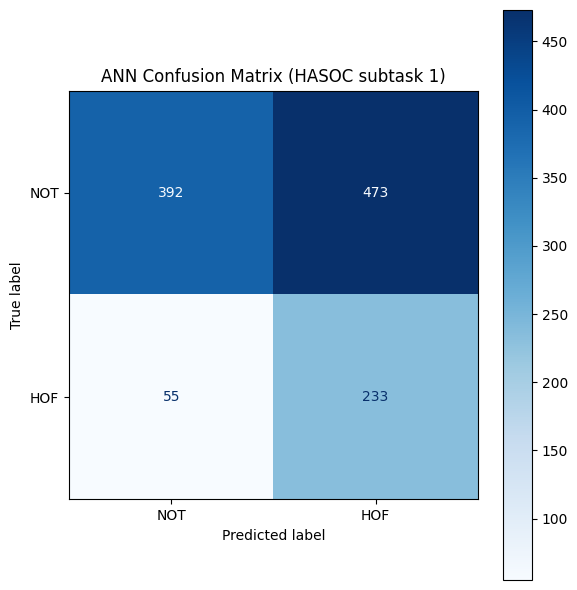

In [61]:
report_ann = "No classification report available for ANN."
cm_ann_data = []
test_loss_ann, test_acc_ann, test_f1_ann, test_precision_ann, test_recall_ann = 0.0, 0.0, 0.0, 0.0, 0.0

if test_ann_loader is not None and y_test is not None and len(y_test) == X_test_tfidf.shape[0]: # Ensure y_test corresponds to X_test_tfidf
    print("\nEvaluating ANN on Labeled Test Set...")
    
    # Ensure loss_fn_ann is defined correctly based on model output and NUM_LABELS
    if actual_output_dim_ann == 1 and NUM_LABELS == 2:
        current_loss_fn_ann_eval = nn.BCEWithLogitsLoss().to(device) # No weights for eval generally
    else:
        current_loss_fn_ann_eval = nn.CrossEntropyLoss().to(device)

    test_loss_ann, test_acc_ann, test_f1_ann, test_precision_ann, test_recall_ann, test_labels_ann, test_preds_ann = eval_ann_model(
        ann_model, test_ann_loader, current_loss_fn_ann_eval, device # Use ann_model (trained one)
    )
    print(f"Test Loss (ANN):      {test_loss_ann:.4f}")
    print(f"Test Accuracy (ANN):  {test_acc_ann:.4f}")
    print(f"Test F1-score (ANN):  {test_f1_ann:.4f}")
    print(f"Test Precision (ANN): {test_precision_ann:.4f}")
    print(f"Test Recall (ANN):    {test_recall_ann:.4f}")

    int_labels_ann   = sorted(list(LABEL_MAP.values()))
    target_names_ann = [k for k, v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]

    report_ann = classification_report(
        y_true=test_labels_ann, y_pred=test_preds_ann, labels=int_labels_ann,
        target_names=target_names_ann, digits=4, zero_division=0
    )
    print("\nClassification Report (ANN):")
    print(report_ann)

    cm_ann = confusion_matrix(test_labels_ann, test_preds_ann, labels=int_labels_ann)
    cm_ann_data = cm_ann.tolist()
    disp_ann = ConfusionMatrixDisplay(cm_ann, display_labels=target_names_ann)
    fig_ann, ax_ann = plt.subplots(figsize=(max(6, NUM_LABELS*2), max(6, NUM_LABELS*2))) # Adjust size for num_labels
    disp_ann.plot(ax=ax_ann, cmap='Blues', values_format='d')
    ax_ann.set_title(f'ANN Confusion Matrix ({DATASET_TYPE} subtask {SUBTASK})')
    fig_ann.tight_layout()
    cm_path_ann = os.path.join(OUTPUT_DIR, f'cm_ann_{DATASET_TYPE}_{SUBTASK}.png')
    fig_ann.savefig(cm_path_ann)
    print(f"Saved ANN confusion matrix to {cm_path_ann}")
    plt.show()

elif test_ann_loader is not None and y_test is None: # Inference only
    print("\nRunning inference with ANN on unlabeled Test Set...")
    ann_model.eval() # Ensure model is in eval mode
    all_preds_ann_inference = []
    with torch.no_grad():
        for batch in tqdm(test_ann_loader, desc="ANN Inference", unit="batch"):
            features = batch['features'].to(device)
            with autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = ann_model(features)
            
            if outputs.shape[1] == 1 and NUM_LABELS == 2: # Binary with single logit
                preds_inf = (torch.sigmoid(outputs.squeeze(1)) > 0.5).long().cpu().tolist()
            else: # Multi-class or binary with 2 logits
                preds_inf = torch.argmax(outputs, dim=1).cpu().tolist()
            all_preds_ann_inference.extend(preds_inf)
    
    inv_label_map = {v: k for k, v in LABEL_MAP.items()}
    pred_strs_ann = [inv_label_map.get(p, 'UNK_PRED') for p in all_preds_ann_inference]
    
    ids_test = []
    if 'id' in df_test.columns:
        ids_test = df_test['id'].tolist()
    # Ensure ids_test matches the length of predictions if df_test was filtered or had issues
    if len(ids_test) != len(all_preds_ann_inference):
        print(f"Warning: Length of test IDs ({len(ids_test)}) does not match number of predictions ({len(all_preds_ann_inference)}). Generating sequential IDs.")
        ids_test = list(range(len(all_preds_ann_inference)))
        
    out_df_ann = pd.DataFrame({
        'id': ids_test, 
        'prediction': all_preds_ann_inference,
        'prediction_str': pred_strs_ann
    })
    out_path_ann = os.path.join(OUTPUT_DIR, f'{DATASET_TYPE}_subtask{SUBTASK}_ann_predictions.csv')
    out_df_ann.to_csv(out_path_ann, index=False)
    print(f"▶️ ANN Inference done. Saved predictions to {out_path_ann}")
    report_ann = "Inference-only mode for ANN; no classification report."
else:
    print("\nSkipping ANN test set evaluation (no labeled test data available or test loader not created).")

## 12. Save ANN Artifacts and Results


Saving ANN artifacts...
Best ANN model saved to: ann_model_output/best_ann_model.pt
ANN Training history plot saved to ann_model_output/ann_training_history.png


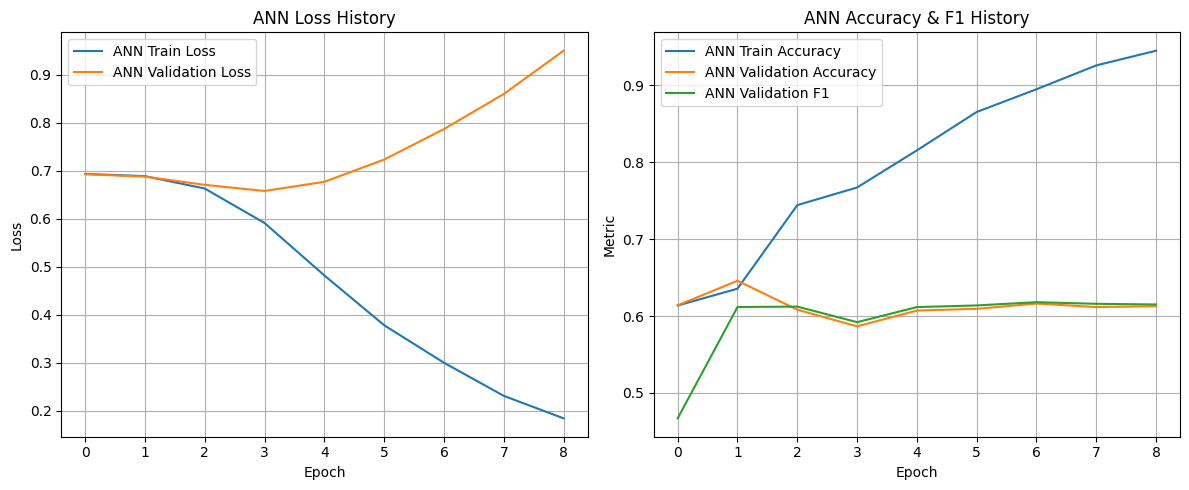

ANN Results saved to ann_model_output/results_ann_HASOC_subtask1.json


In [62]:
print("\nSaving ANN artifacts...")

# --- Save ANN Model ---
ann_model_save_path = os.path.join(OUTPUT_DIR, 'best_ann_model.pt')
if best_model_state_ann:
    torch.save(best_model_state_ann, ann_model_save_path)
    print(f"Best ANN model saved to: {ann_model_save_path}")
else: # If early stopping wasn't used or didn't improve
    final_ann_model_path = os.path.join(OUTPUT_DIR, 'final_ann_model.pt')
    torch.save(ann_model.state_dict(), final_ann_model_path)
    print(f"Final ANN model state saved to {final_ann_model_path} (no best state from early stopping or no validation).")


# --- Plot ANN Training History ---
if history_ann['train_loss']: # Check if history exists
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_ann['train_loss'], label='ANN Train Loss')
    if history_ann.get('val_loss'): plt.plot(history_ann['val_loss'], label='ANN Validation Loss')
    plt.title('ANN Loss History')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_ann['train_acc'], label='ANN Train Accuracy')
    if history_ann.get('val_acc'): plt.plot(history_ann['val_acc'], label='ANN Validation Accuracy')
    if history_ann.get('val_f1'): plt.plot(history_ann['val_f1'], label='ANN Validation F1')
    plt.title('ANN Accuracy & F1 History')
    plt.xlabel('Epoch'); plt.ylabel('Metric'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    history_plot_path_ann = os.path.join(OUTPUT_DIR, 'ann_training_history.png')
    plt.savefig(history_plot_path_ann)
    print(f"ANN Training history plot saved to {history_plot_path_ann}")
    plt.show()
else:
    print("No training history to plot for ANN (e.g., training was skipped).")


# --- Save ANN Configuration and Results to JSON ---
results_ann = {
    'config': config_ann_dict, # from Cell 2
    'training_info': {
        'epochs_run': len(history_ann['train_loss']) if history_ann['train_loss'] else 0,
        'total_training_time_seconds': total_training_time_seconds_ann,
        'best_validation_loss': best_val_loss_ann if best_model_state_ann is not None else None,
        'best_epoch': best_epoch_ann if best_model_state_ann is not None else None
    },
    'history': history_ann,
    'test_metrics': { # These will be 0 if evaluation on labeled test set was skipped
        'loss': test_loss_ann,
        'accuracy': test_acc_ann,
        'f1_score_weighted': test_f1_ann,
        'precision_weighted': test_precision_ann,
        'recall_weighted': test_recall_ann
    },
    'classification_report': report_ann, # from Cell 11
    'confusion_matrix': cm_ann_data # from Cell 11
}
results_filename_ann = f"results_ann_{DATASET_TYPE}_subtask{SUBTASK.lower()}.json"
results_path_ann = os.path.join(OUTPUT_DIR, results_filename_ann)
with open(results_path_ann, 'w') as f:
    json.dump(results_ann, f, indent=4)
print(f"ANN Results saved to {results_path_ann}")